In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import display, Markdown
%matplotlib inline

In [2]:
def redemption_check(redemption_type):
    if redemption_type not in ['cash', 'travel']:
            raise AttributeError('Set `redemption_type` to points or travel')

def money_str(val_tuple):
    eq_text = tuple('\${:,.0f}'.format(i) for i in list(val_tuple))
    return eq_text

def printmd(text):
    display(Markdown(text))

class rewards_viz():
    def __init__(self, x_array, redemption_type, first_year=True, redeem_points=True):
        self._x = x_array
        self._redemption_type = redemption_type
        self._first_year = first_year
        self._redeem_points = redeem_points
        self.card_df = None
        self.y_dict = None
    
    @staticmethod
    def reserve(x, redemption_type, first_year, redeem_points):
        beta_dict = {'cash':.03, 'travel':.045}
        int_dict = {'cash':500, 'travel':750}
        redemption_check(redemption_type)
        m = beta_dict[redemption_type]
        y = m*x-150
        if first_year is True:
            if redeem_points is True:
                b = int_dict[redemption_type]
                y = y+b
        return y
    
    @staticmethod
    def preferred(x, redemption_type, first_year, redeem_points):
        beta_dict = {'cash':.02, 'travel':.025}
        int_dict = {'cash':500, 'travel':625}
        redemption_check(redemption_type)
        m = beta_dict[redemption_type]
        y = m*x-95
        if first_year is True:
            if redeem_points is True:
                b = int_dict[redemption_type] + 95
            else:
                b = 95
            y=y+b
        return y
    
    @staticmethod
    def freedom(x, redemption_type, first_year, redeem_points):
        y = .015*x
        if first_year is True:
            b=150
            y=y+b
        return y
    
    @staticmethod
    def equilibrium(eqn1, eqn2, redemption_type, first_year, redeem_points):
        x= np.array([0,1000])
        result1 = eqn1(x, redemption_type, first_year, redeem_points)
        result2 = eqn2(x, redemption_type, first_year, redeem_points)
        b1 = result1[0]
        b2 = result2[0]
        m1 = (result1[1] - b1) / x[1]
        m2 = (result2[1] - b2) / x[1]
        x_eq = (b2-b1) / (m1-m2)
        y_eq = eqn1(x_eq, redemption_type, first_year, redeem_points)
        return int(x_eq), int(y_eq)
    
    def calculate_y_dict(self):
        r = self.reserve(self._x, self._redemption_type, self._first_year, self._redeem_points)
        p = self.preferred(self._x, self._redemption_type, self._first_year, self._redeem_points)
        f = self.freedom(self._x, self._redemption_type, self._first_year, self._redeem_points)
        self.y_dict =  {'r':r, 'p':p, 'f':f}
    
    def generate_data(self):
        if self.y_dict is None:
            self.calculate_y_dict()
        spend = self._x
        df = pd.DataFrame({'spend':spend,
                           'reserve':self.y_dict['r'],
                           'preferred':self.y_dict['p'],
                           'freedom':self.y_dict['f']})
        df = pd.melt(df, id_vars='spend')
        self._card_df = df

    def comparison_pyplot(self):
        sns.set_style("ticks")
        if self.card_df is None:
            self.generate_data()
        fig, ax = plt.subplots(figsize=(8,6))
        
        eq_rp = self.equilibrium(self.reserve, self.preferred, self._redemption_type, self._first_year, self._redeem_points)
        eq_rf = self.equilibrium(self.reserve, self.freedom, self._redemption_type, self._first_year, self._redeem_points)
        eq_pf = self.equilibrium(self.preferred, self.freedom, self._redemption_type, self._first_year, self._redeem_points)
        
        ax.plot(x, self.y_dict['r'], label='Chase Reserve', color='#4c72b0')
        ax.plot(x, self.y_dict['p'], label='Chase Preferred', color='#64b5cd')
        ax.plot(x, self.y_dict['f'], label='Chase Freedom', color='#55a868', linestyle='--')
        
        for eq in [eq_rp, eq_rf, eq_pf]:
            if eq == eq_rp:
                label = 'Equlibrium Point'
            else: label = None
            ax.plot(eq[0], eq[1], marker='o', markersize=5, color='#c44e52', label= label)

        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.ylabel('Total Cashback Bonus ($)')
        plt.xlabel('Total Dining/Travel Spend ($)')

        fmt = '${x:,.0f}'
        tick = mtick.StrMethodFormatter(fmt)
        ax.yaxis.set_major_formatter(tick) 
        ax.xaxis.set_major_formatter(tick)
        ax.set_xlim(self._x.min(), self._x.max())

        sns.despine(offset=1, trim=True)

        printmd('Reserve > Preferred @ **Spend:** {0} || **CashBack:** {1}'.format(money_str(eq_rp)[0], money_str(eq_rp)[1]))
        printmd('Reserve > Freedom @ **Spend:**{0} || **CashBack:**{1}'.format(money_str(eq_rf)[0], money_str(eq_rf)[1]))
        printmd('Preferred > Freedom @ **Spend:**{0} || **CashBack:**{1}'.format(money_str(eq_pf)[0], money_str(eq_pf)[1]))
        
    @property
    def reinitialize(self):
        self.calculate_y_dict()
        self.generate_data()

In [3]:
x = np.arange(0, 51000, 1000)

In [4]:
matrix = pd.DataFrame.from_dict({'Points to Travel':[True, False],'First Year':[True, False]})
matrix.index = matrix.columns
matrix

,First Year,Points to Travel
First Year,True,True
Points to Travel,False,False


Reserve > Preferred @ **Spend:** \$1,250 || **CashBack:** \$656

Reserve > Freedom @ **Spend:**\$-15,000 || **CashBack:**\$-75

Preferred > Freedom @ **Spend:**\$-47,499 || **CashBack:**\$-562

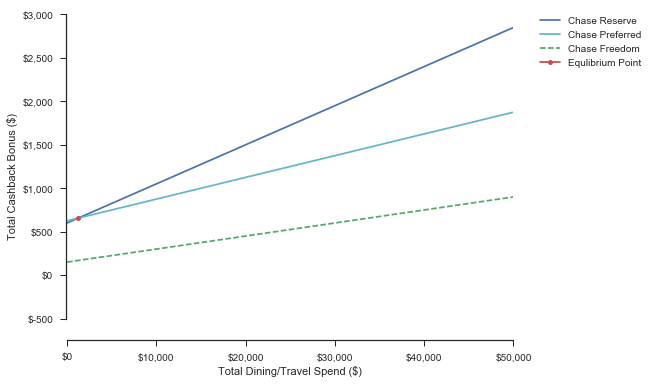

In [5]:
rv = rewards_viz(x, redemption_type='travel', first_year=True)
rv.comparison_pyplot()

Reserve > Preferred @ **Spend:** \$15,000 || **CashBack:** \$800

Reserve > Freedom @ **Spend:**\$-13,333 || **CashBack:**\$-50

Preferred > Freedom @ **Spend:**\$-69,999 || **CashBack:**\$-899

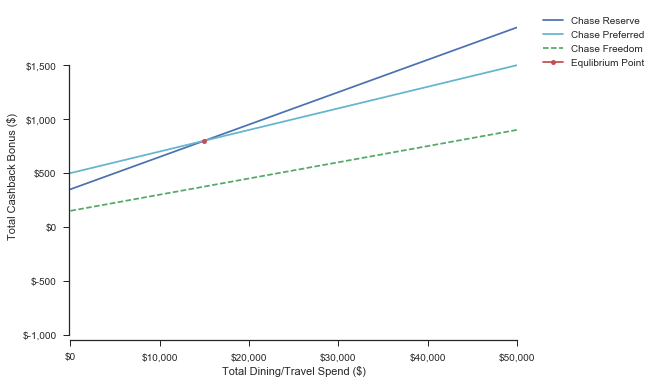

In [6]:
rv = rewards_viz(x, redemption_type='cash', first_year=True)
rv.comparison_pyplot()

Reserve > Preferred @ **Spend:** \$5,500 || **CashBack:** \$15

Reserve > Freedom @ **Spend:**\$10,000 || **CashBack:**\$150

Preferred > Freedom @ **Spend:**\$18,999 || **CashBack:**\$284

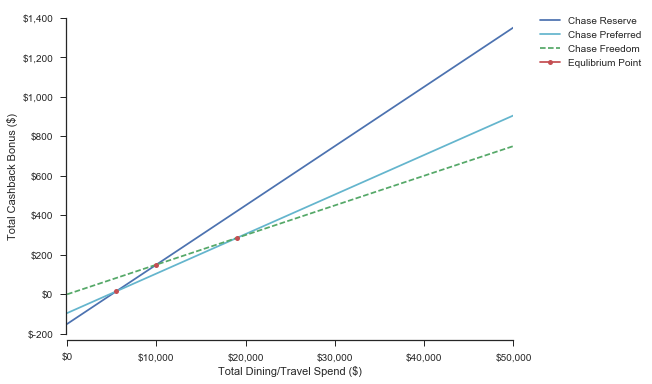

In [7]:
rv = rewards_viz(x, redemption_type='cash', first_year=False)
rv.comparison_pyplot()

Reserve > Preferred @ **Spend:** \$2,750 || **CashBack:** \$-26

Reserve > Freedom @ **Spend:**\$5,000 || **CashBack:**\$75

Preferred > Freedom @ **Spend:**\$9,499 || **CashBack:**\$142

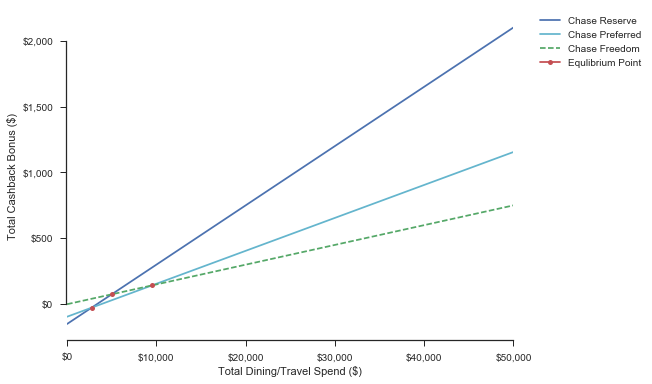

In [8]:
rv = rewards_viz(x, redemption_type='travel', first_year=False)
rv.comparison_pyplot()

In [9]:
# ! jupyter nbconvert card-comparison.ipynb --to markdown